In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import random
from IPython.display import HTML
import os

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
import os

# Specify the correct paths for folder1 and folder2
folder1_path = "/Users/pritipuniya/folder1"
folder2_path = "/Users/pritipuniya/Downloads/folder2"

# Check if the directory exists
if os.path.exists(folder2_path):
    print(f"Directory '{folder2_path}' exists.")
    
    # Use folder2_path in your image_dataset_from_directory function
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        folder2_path,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
else:
    print(f"Directory '{folder2_path}' does not exist.")

Directory '/Users/pritipuniya/Downloads/folder2' exists.
Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
print("Class names:", class_names)



Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [8]:
len(dataset)

68

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


In [11]:
#lets visualize this image

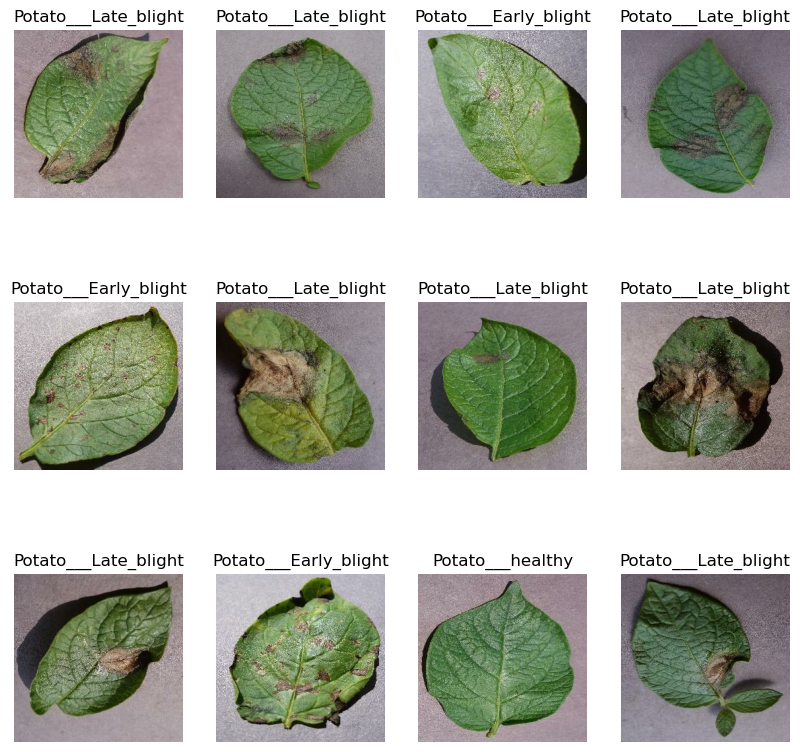

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
    

In [13]:
#splitting the data in train test split

In [14]:
#80% ==>training,
#20% ==>validation ,10% test

In [15]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds=dataset.take(54)
len(train_ds)

54

In [17]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds=test_ds.take(6)

In [20]:
test_ds=test_ds.skip(6)

In [21]:
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
#cache and prefetch the dataset

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [27]:
#Data Augmentation


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
#CNN for image classification

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [38]:
#compiling the model

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 86s 2s/step - loss: 0.9021 - accuracy: 0.4688 - val_loss: 0.7858 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 71s 1s/step - loss: 0.7105 - accuracy: 0.6765 - val_loss: 0.6627 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 89s 2s/step - loss: 0.5206 - accuracy: 0.7865 - val_loss: 0.3683 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 78s 1s/step - loss: 0.3888 - accuracy: 0.8339 - val_loss: 0.2061 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 80s 1s/step - loss: 0.2337 - accuracy: 0.9207 - val_loss: 0.1875 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 94s 2s/step - loss: 0.1566 - accuracy: 0.9444 - val_loss: 0.1240 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.1405 - accuracy: 0.9473 - val_loss: 0.0675 - val_accuracy: 0.9688
Epoch 8/50
54/54 [==

In [41]:
 scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 380ms/step - loss: 0.0646 - accuracy: 0.9805


In [42]:
scores

[0.06455650925636292, 0.98046875]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

50

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9020549058914185,
 0.7104618549346924,
 0.520576000213623,
 0.38878172636032104,
 0.23370999097824097]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

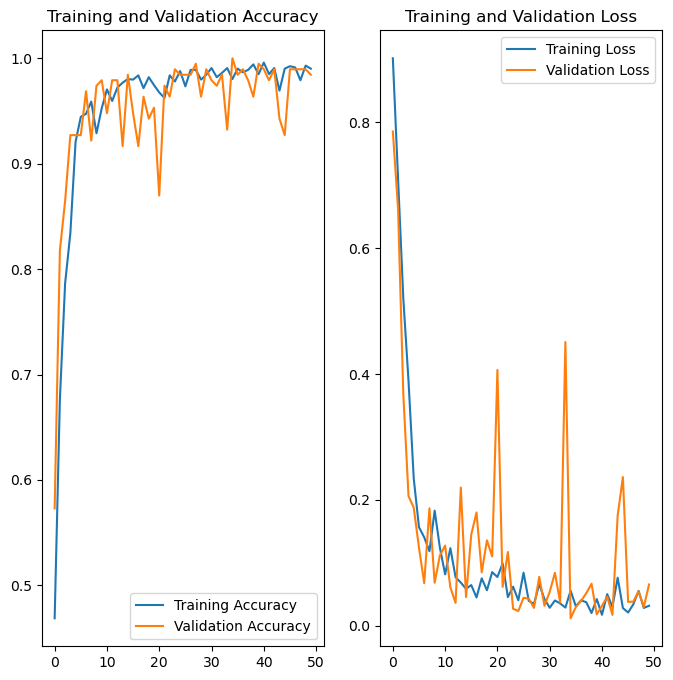

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
#Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 494ms/step
predicted label: Potato___Late_blight


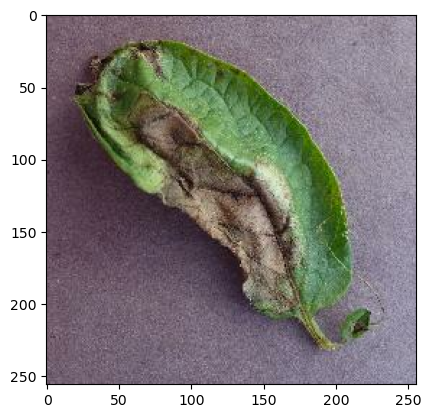

In [52]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


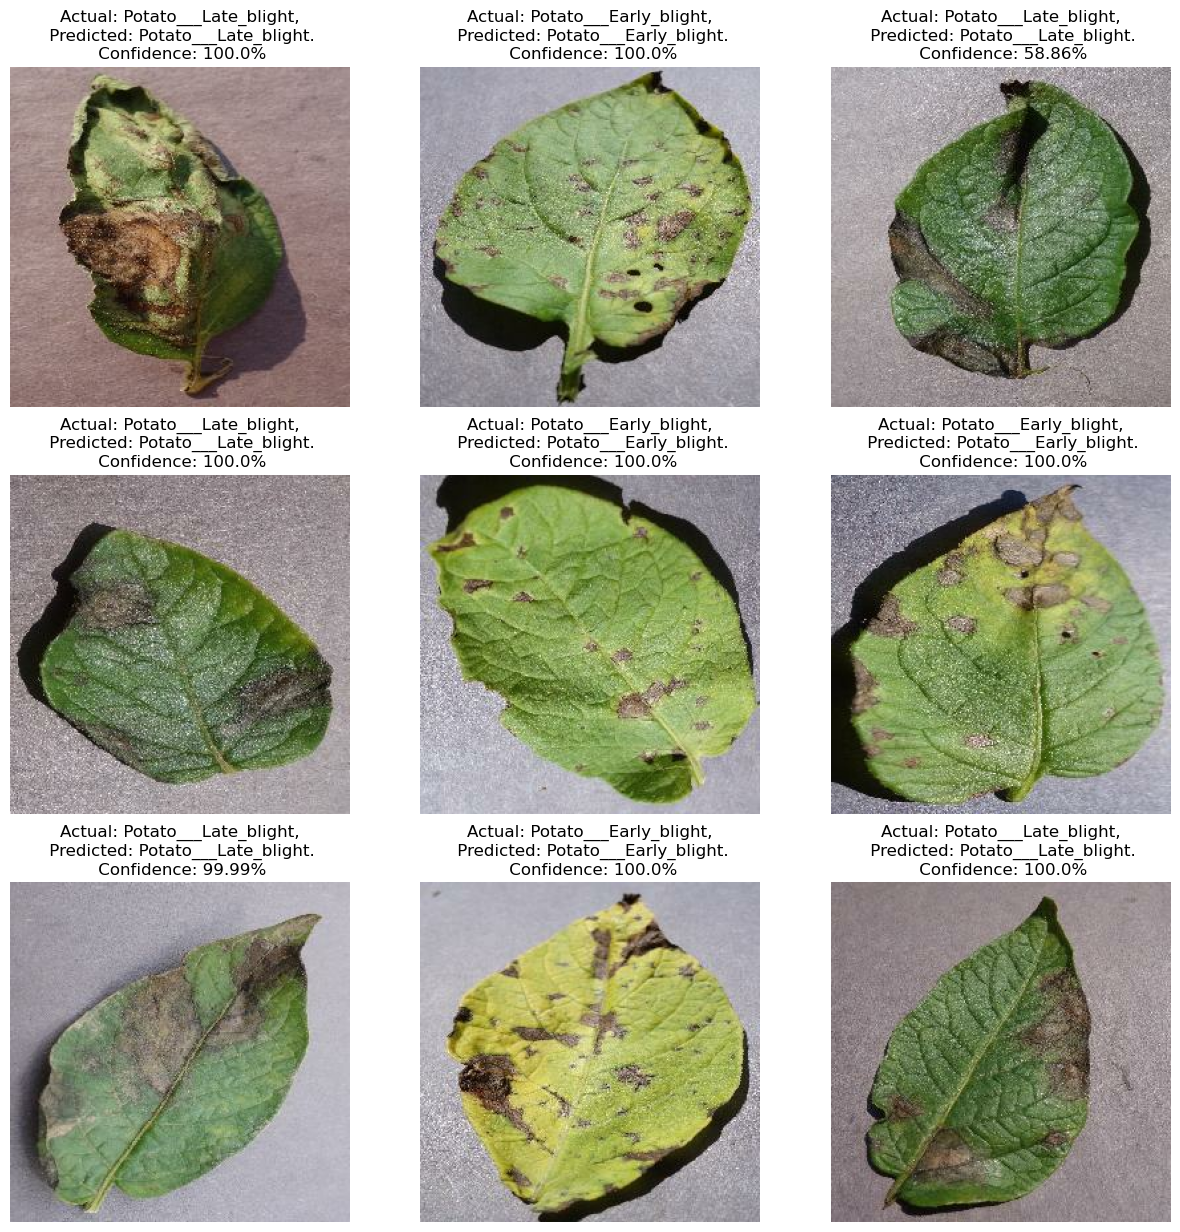

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
#saving the model

FileNotFoundError: [Errno 2] No such file or directory: '../models'